# Generating Shakespeare character by character

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import torch
from nanoLLMs.misc import get_batch
from nanoLLMs.model.gpt2 import GPT2
from nanoLLMs.model import LLMMamba, MambaConfig
from nanoLLMs.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_char/prepare.py` file in order to have our data setup.

In [8]:
! python ../data/shakespeare_char/prepare.py 

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In this dataset we have 65 unique characters that forms our vocabulary size, 1M tokens for training and 100k for validation.

In [3]:
data_dir = "../data/shakespeare_char/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itos = meta["itos"]
    stoi = meta["stoi"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form words and sentences.

The function `encode` and `decode` will help to bridge the gap between produced GPT output into readable characters and readable characters into data.

We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian literature.

In [4]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: "".join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
y = decode(x.tolist())
assert shakpeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


We then choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [11]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 813889


We instantiate also our `GPTTrainer` code from `nanoLLMs/trainer/gpt_trainer.py`. 

In [ ]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially stops the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [5]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=5000, batch_size=2*128, patience=2000, save_every=200
)

NameError: name 'trainer' is not defined

Let's see the loss curve from this training and also generate some text !

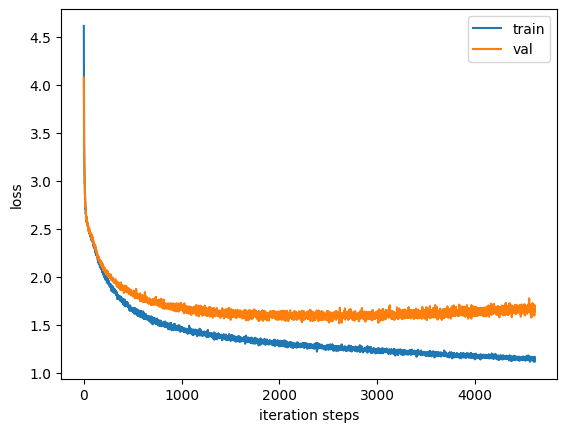

In [29]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/loss.png")

We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the text generation. 

In [30]:
model.eval()
x = encode("the king will \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 2 * 256, temperature=1.0, top_k=None)
print(decode(y[0].tolist()))

100%|██████████| 512/512 [00:00<00:00, 1173.41it/s]

the king will 
Both every 'lie enter'd and be it, ho!'
And beat the salf; O, Ichold you shall be the
return, I may crie-conduct, look to.

GLOUCESTER:
And there's a mile calles of it is short!

FRIAR LED:
Rope and sent it shall degree no outward! he was
of his bating worthy Corioli long
And himself we have been daughter of me.

GLOUCESTER:
No, then, take him up, poor silent for Bolingbroke
It of them false stay.

TYBALT:
Why, then, let here be come to down it beg
Hath wine to my heart beard. Is there
Is my life's wars his


# Text generation with Mamba

In [2]:
data_dir = "../data/shakespeare_char/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itos = meta["itos"]
    stoi = meta["stoi"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)


In [3]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: "".join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
y = decode(x.tolist())
assert shakpeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


In [4]:
config = MambaConfig(d_model=32, n_layers=6, d_state=16)
model = LLMMamba(config, vocab_size=vocab_size)
model = model.to(device)

In [5]:
max_iters, batch_size = 1000, 32
counter, best_val_step = 0, 0
block_size = 64
get_batch_fn = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

In [ ]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


In [7]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=1000, batch_size=2*128, patience=2000, save_every=200
)

Iter :999/1000 Train Loss 1.515e+00 / Eval Loss 1.741e+00: 100%|██████████| 1000/1000 [11:28<00:00,  1.45it/s]


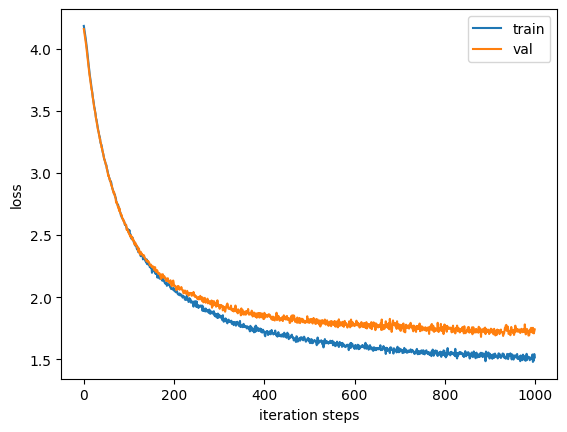

In [8]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/mamba_loss.png")

In [9]:
model.eval()
x = encode("the king will \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 2 * 256, temperature=1.0, top_k=None)
print(decode(y[0].tolist()))

O?
Comes is
sworn at heavy? what entends,
But this love he made bolirio,
I never
By sure, sost must servity?
Can'll, proud not many labout to
Selliut!
If recousi.

PRINCE EDWAMAL:
How that there's not a between sound redrip thy day Do comscantest.

MILTRold:
I would Becking benecious of that what.

CORIOLANUS:
Thou wripited therefore he the phating,
To morous!
The sire as a mid dowr thyself will
'Tat widows he, if her hell:
For valick out of that till he empusning me, from there's forhey
no post bear too to


# xLSTM 

In [35]:
from nanoLLMs.model.xlstm import xLSTM

In [29]:
embed_dim = 128
hidden_size = 64
num_layers = 2
num_blocks = 3
dropout = 0.1
lstm_type = "mlstm"

model = xLSTM(vocab_size, embed_dim, hidden_size, num_layers, num_blocks, dropout, device)
model.to(device)
print("xLSTM number of parameters:", sum(p.numel() for p in model.parameters()))

xLSTM number of parameters: 265537


In [30]:
max_iters, batch_size = 1000, 32
counter, best_val_step = 0, 0
block_size = 64
get_batch_fn = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

In [ ]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_char/")

Created checkpoint directory at ../metadata/shakespeare_char/


In [32]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=1000, batch_size=batch_size, patience=2000, save_every=200
)

Iter :999/1000 Train Loss 1.859e+00 / Eval Loss 1.863e+00: 100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


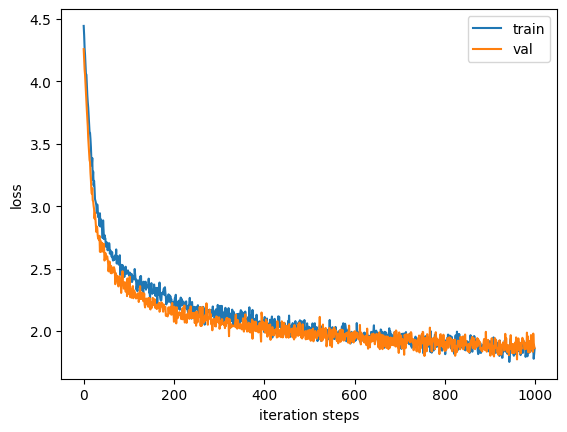

In [33]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_char/xlstm_loss.png")

In [34]:
model.eval()
x = encode("the king will \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 256, temperature=1.0, top_k=None)
print(decode(y[0].tolist()))

child, and you, Bit't thy maidide,
Franhis,
That I dare readfort, of the blive know you naty
And
The might, stientines out fath. We and some:
Now in that packe finemony ome her, him from constens
So'l I prices of conted, men:
Thush a tchievend good deconce
